## Preamble

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import describe
pd.options.display.max_columns = 12
pd.options.display.max_rows = 24

# disable warnings in Anaconda
import warnings
warnings.simplefilter('ignore')

# plots inisde jupyter notebook
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style='darkgrid', palette='muted')
color_scheme = {
    'red': '#F1637A',
    'green': '#6ABB3E',
    'blue': '#3D8DEA',
    'black': '#000000'
}

import datetime as dt
import xgboost as xgb

In [2]:
def smape(y_pred, y_true):
    # calculate error
    denom = (abs(y_pred) + abs(y_true)) / 2
    errors = abs(y_pred - y_true) / denom
    return 100 * np.sum(errors) / len(y_true)

In [3]:
def serie_split(s, fcast_len = 90):
    """
    We split our datasets: year 2017 is used for validation and the rest is for training.
    As our goal is to predict the first 90 days of 2018, we use only the first 90 days for validation.
    """
    train = s.iloc[s.index < '2017-01-01']
    test = s.iloc[s.index >= '2017-01-01'].iloc[:fcast_len]
    
    return train, test

## Load data

In [4]:
df = pd.read_csv('./data/train.csv')
df['date'] = pd.to_datetime(df['date'])
df.index = pd.DatetimeIndex(df['date'])

## Feature extraction

In [5]:
from rolling import Rolling

In [6]:
def compute_over_interval(functions, interval):
    return np.array([f(interval) for f in functions])

def features(prev_values, current_date, metadata=None):
    last_2months = prev_values[-60:]
    last_month = prev_values[-30:]
    last_week = prev_values[-7:]
    
    featureset = [
        lambda x: np.median(x),
        #lambda x: np.mean(x),
        #lambda x: np.min(x),
        #lambda x: np.max(x),
        lambda x: np.var(x),
    ]
    
    weekday_v = np.zeros(7)
    weekday_v[current_date.dayofweek] = 1
    
    return np.concatenate([
        #weekday_v,
        last_2months,
        compute_over_interval(featureset, last_month),
        prev_values[:30], # one month almost a year before
    ])


## Training

In [7]:
def train_and_validate(serie):
    r = Rolling(window=365, extract_features=features)

    model = xgb.XGBRegressor(n_jobs=-1)
    
    train, test = serie_split(serie)
    train_X, train_y = r.make_training_data(train)

    model.fit(train_X, train_y)

    y = r.predict(model.predict, train)

    return smape(y, test)

## Run all models

In [8]:
errors = []
for store in range(1,11):
    for item in range(1,51):
        sales = df[(df["store"] == store) & (df["item"] == item)]["sales"]
        error = train_and_validate(sales)
        print(error)
        errors.append(error)

24.32268357790855
17.925941240326452
17.610167861187172
24.217076321514813
28.93004724247833
15.893861872195483
14.657317402518682
11.862404759734588
15.930829554994835
13.078254832092334
11.976070739326957
12.27882886748714
13.506578249263832
15.711301800346291
12.654330260622103
22.35874471780524
17.205520255965943
14.607654329446405
17.61333939761225
16.084488965176835
17.589614625132374
19.143579025370485
18.19534312600617
14.93693836282566
11.672018861152951
15.69342221716513
24.207569017130968
12.632455179183456
14.475208070437898
17.42503085884105
16.233322689317724
16.482890828597903
14.57254782084041
19.892241382973044
11.697544258731693
11.910984671320344
20.947737064674254
13.03096075652807
18.621800253424055
22.668135446312025
26.55124950535956
17.38629564323389
13.96091000547529
22.740907833410958
12.529085053571475
12.266210673756783
24.008257908199866
14.479345388860876
17.91561093963906
13.632309643618449
18.81126269467601
13.262695322762086
13.905099784350677
18.767680

16.142386278423235
18.896314498130767
19.60221750458991
17.814903593541736
14.576967910318237
20.640613124445565
13.005415367931985
13.487741676000507
23.317401695506856
15.405157524941231
18.121303771472874
12.620194757992099
22.124662020241367
13.053423481851617
20.134746194368173
19.05500191169584
23.504784451484042
13.60211505945826
14.886756359034322
12.71917171248621
11.263535881113073
12.114957669481399
12.095805395504259
13.05596377689365
11.021969090657267
16.159957147939743
10.3222894022985
17.741388331031224
21.05137738837462
11.369959423991686
16.706891832353374
12.766766399830598
16.985368447104523
13.032377203523449
18.06215690465973
15.295345782950381
11.842158080324442
15.902749613529114
17.221064620383476
9.481189657044311
11.726339651800684
15.833997614165446
12.808223895310789
14.796832782930391
12.113895339920699
21.0161783251006
12.44629893351288
10.721173461424728
19.372227706500283
12.806815897160057
14.591332125017535
17.16133871602053
23.658658505963686
14.5672

In [9]:
print("SMAPE = %f" % np.mean(errors))

SMAPE = 16.626744


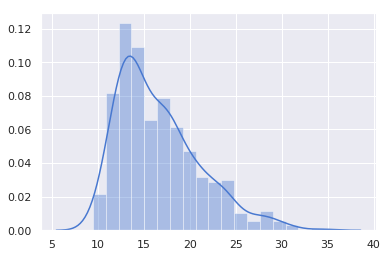

In [10]:
sns.distplot(errors)
plt.savefig('xgboost_features.svg')
plt.show()